In [2]:
!wget -O bert.tar.gz https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2?tf-hub-format=compressed

!tar -xf bert.tar.gz -C ./bert

In [6]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

!pip install sentencepiece

--2020-10-14 16:14:43--  https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16781 (16K) [text/plain]
Saving to: ‘tokenization.py.1’

tokenization.py.1   100%[===================>]  16.39K  --.-KB/s    in 0.005s  

2020-10-14 16:14:43 (3.38 MB/s) - ‘tokenization.py.1’ saved [16781/16781]

     |████████████████████████████████| 1.1MB 6.9MB/s 


In [1]:
import os
import random

import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import tensorflow.keras.backend as K
import tokenization
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

In [3]:
MAX_SEQUENCE_LENGTH = 128

In [4]:
tokenizer = tokenization.FullTokenizer('bert/assets/vocab.txt', True)

In [5]:
data = pd.read_csv('index.csv', index_col=0)
print(data.shape)
# data_aug = pd.read_csv('resources/data_augment_ua_en_cn_en_ua.csv', index_col=0)
# print(data_aug.shape)
# data = pd.concat([data, data_aug])
# print(data.shape)
# data.head()

(165, 3)


In [6]:
data['descr'] = data['description'].str.replace("’", "'")

In [7]:
train_data = data[data['user'] <= 5].copy()
valid_data = data[(data['user'] >= 6) & (data['user'] <= 7)].copy()
test_data = data[data['user'] > 7].copy()

In [8]:
def _get_masks(tokens, max_seq_length):
    return [1] * len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_segments(tokens, max_seq_length):
    return [1] * len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_ids(tokens, tokenizer, max_seq_length):
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length - len(token_ids))
    return input_ids

def _convert_to_bert_inputs(t, tokenizer, max_sequence_length):
    stoken = ["[CLS]"] + t + ["[SEP]"]
    input_ids = _get_ids(stoken, tokenizer, max_sequence_length)
    input_masks = _get_masks(stoken, max_sequence_length)
    input_segments = _get_segments(stoken, max_sequence_length)
    return [input_ids, input_masks, input_segments]

def compute_bert_input_arrays(rows, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for row in rows:
        t = tokenizer.tokenize(row)
        ids, masks, segments = _convert_to_bert_inputs(t, tokenizer, max_sequence_length)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]


In [9]:
words = [
    'кінь', 'зебра', 'корова', 'ведмідь', 'олень', 
    'страус', 'курка', 'пінгвін', 'сова', 'лебідь', 
    'морквина', 'яблуко', 'банан', 'картопля', 'лимон'
]

In [10]:
def get_X_y(data, train=1):
    X = compute_bert_input_arrays(data['descr'].values, tokenizer, MAX_SEQUENCE_LENGTH)
    y = data['word'].apply(lambda x: words.index(x))
    return X, y

In [11]:
X_train, y_train = get_X_y(train_data, 1)
X_valid, y_valid = get_X_y(valid_data, 1)
X_test, y_test = get_X_y(test_data, 0)

In [12]:
def create_model():
    input_ids = layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
    input_masks = layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
    input_segments = layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')
    bert_layer = hub.KerasLayer('./bert', trainable=False)
    bert_merged_x, sequence_output = bert_layer([input_ids, input_masks, input_segments])
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out = layers.Dense(15, activation="softmax")(x)

    model = models.Model(
        inputs = [
            input_ids, 
            input_masks, 
            input_segments
        ], 
        outputs = out)
    
    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_ids[0][0]                  
                                                                 input_masks[0][0]     

In [13]:
check_save = callbacks.ModelCheckpoint(
    'resources/model_augment_ua_en_cn_en_ua_{epoch:02d}.hdf5',
     monitor='val_loss', 
     verbose=1, 
     save_best_only=True,
     save_weights_only=True, 
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=75, 
    validation_data=(X_valid, y_valid), 
    batch_size=8,
    # callbacks=[check_save],
    verbose=1
)

Epoch 1/75
10/10 [==============================] - 1s 124ms/step - loss: 2.7874 - accuracy: 0.1067 - val_loss: 2.6704 - val_accuracy: 0.0667
Epoch 2/75
10/10 [==============================] - 1s 57ms/step - loss: 2.6682 - accuracy: 0.0667 - val_loss: 2.5969 - val_accuracy: 0.1333
Epoch 3/75
10/10 [==============================] - 1s 57ms/step - loss: 2.6094 - accuracy: 0.1467 - val_loss: 2.5499 - val_accuracy: 0.1667
Epoch 4/75
10/10 [==============================] - 1s 57ms/step - loss: 2.4903 - accuracy: 0.1733 - val_loss: 2.4769 - val_accuracy: 0.2667
Epoch 5/75
10/10 [==============================] - 1s 57ms/step - loss: 2.3746 - accuracy: 0.2133 - val_loss: 2.4180 - val_accuracy: 0.3000
Epoch 6/75
10/10 [==============================] - 1s 57ms/step - loss: 2.3273 - accuracy: 0.3067 - val_loss: 2.3783 - val_accuracy: 0.2333
Epoch 7/75
10/10 [==============================] - 1s 57ms/step - loss: 2.2290 - accuracy: 0.2933 - val_loss: 2.3490 - val_accuracy: 0.2000
Epoch 8/75
1

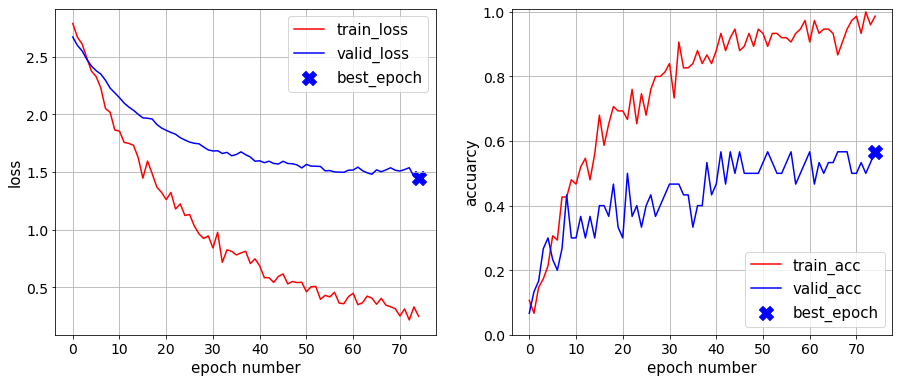

In [19]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='red', label='train_loss')
plt.plot(history.history['val_loss'], color='blue', label='valid_loss')
plt.scatter([74], [1.4460], color='blue', s=200, label='best_epoch', marker='X')
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('epoch number', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='red', label='train_acc')
plt.plot(history.history['val_accuracy'], color='blue', label='valid_acc')
plt.scatter([74], [0.5667], color='blue', s=200, label='best_epoch', marker='X')
plt.legend(fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('epoch number', fontsize=15)
plt.ylabel('accuarcy', fontsize=15)
plt.ylim(0, 1.01)
plt.grid()

0.5833333333333334


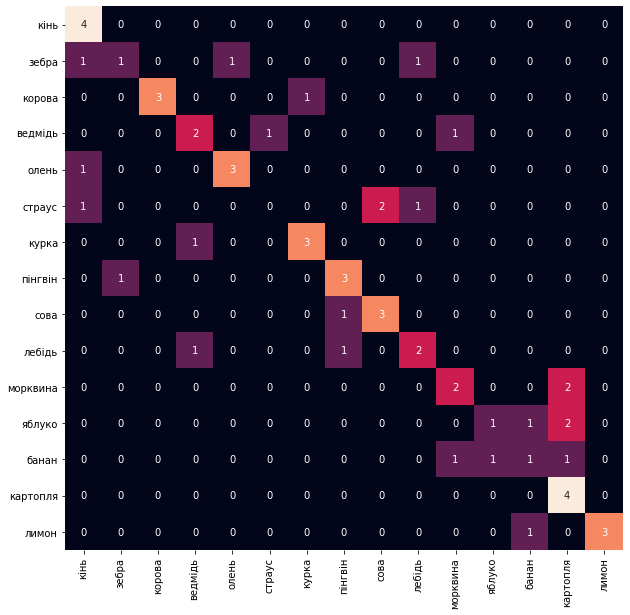

In [15]:
res = model.predict(X_test).argmax(axis=1)
print(metrics.accuracy_score(y_test, res))
m = metrics.confusion_matrix(y_test, res)
df_cm = pd.DataFrame(m, index = words, columns = words)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, cbar=False)

In [20]:
test_data['pred'] = res
test_data['real'] = y_test
no_ok = test_data[test_data['pred'] != test_data['real']]
for i in range(no_ok.shape[0]):
    print(no_ok.iloc[i]['descr'], '|', no_ok.iloc[i]['word'], '|', words[no_ok.iloc[i]['pred']])

Тварина, яка має гриву, але не кінь. | зебра | кінь
Впадає в сплячку взимку, любить мед. | ведмідь | морквина
Цим звіром нарікають людей, які чогось не розуміють. | олень | кінь
Птах, який ховає голову в пісок. | страус | сова
Домашня птиця, літає погано і недалеко. | курка | ведмідь
Красивий, білий птах, переважно перебуває у воді. | лебідь | пінгвін
Овоч, який дуже полюбляють зайці, конусної форми. | морквина | картопля
Кислий, солодкий із кісточками всередині, корисно їсти зі шкіркою. | яблуко | банан
Подовгуватий фрукт, який їдять в очищеному вигляді, без шкірки. | банан | картопля
Жовтий, овальний на вигляд фрукт. | лимон | банан
Парнокопитна тварина, дика, має чорно-білі смуги | зебра | олень
Ховає голову в пісок | страус | кінь
Чорно-біла птиця, живе на південному полюсі | пінгвін | зебра
Фрукт, росте на деревах, дозріває вкінці літа, популярний сорт цього фрукта голден | яблуко | картопля
великий птах, що не вміє літати, але може швидко бігати. Часто можна бачити в зоопарку. | 